In [1]:
import dotenv
import os
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

dotenv.load_dotenv()

llm = ChatOpenAI(model="gpt-4o-mini")

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(embedding_function=embeddings)

c:\Users\a931e\miniconda3\envs\12\Lib\site-packages\onnxruntime\capi\onnxruntime_validation.py:26: UserWarning: Unsupported Windows version (11). ONNX Runtime supports Windows 10 and above, only.
  warnings.warn(


In [2]:
import ast
def my_exec(script, globals=None, locals=None):
    '''Execute a script and return the value of the last expression'''
    stmts = list(ast.iter_child_nodes(ast.parse(script)))
    if not stmts:
        return None
    if isinstance(stmts[-1], ast.Expr):
        # the last one is an expression and we will try to return the results
        # so we first execute the previous statements
        if len(stmts) > 1:
            exec(compile(ast.Module(body=stmts[:-1]), filename="<ast>", mode="exec"), globals, locals)
        # then we eval the last one
        return eval(compile(ast.Expression(body=stmts[-1].value), filename="<ast>", mode="eval"), globals, locals)
    else:
        # otherwise we just execute the entire code
        return exec(script, globals, locals)

In [31]:
from typing import Annotated
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import List, TypedDict
from langchain_core.tools import tool


from langchain_core.messages import SystemMessage
from langgraph.prebuilt import InjectedState, InjectedState, InjectedState, ToolNode

from langgraph.graph import END
from langgraph.prebuilt import tools_condition

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://eri24816.tw/post/summer_intern/",),
    bs_kwargs=dict(
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(MessagesState):
    context: List[Document]
    
@tool(response_format="content_and_artifact")
def get_website_content(url: str):
    """Get the content of a website"""
    loader = WebBaseLoader(web_paths=(url,))
    docs = loader.load()
    return docs[0].page_content, docs

@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query from the database"""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

@tool(response_format="content")
def execute(query: str):
    """Execute a python code"""
    from io import StringIO
    from contextlib import redirect_stdout
    import traceback
    
    f = StringIO()
    with redirect_stdout(f):
        try:
            ret = my_exec(query)
        except Exception:
            error_stringio = StringIO()
            traceback.print_exc(file=error_stringio)
            return {"code": query, "result": f.getvalue(), "error": error_stringio.getvalue(), "status": "error"}
    return {"code": query, "result": f.getvalue() + "\n" + str(ret), "status": "success"}
    
memory = MemorySaver()
# graph = graph_builder.compile(checkpointer=memory)
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [execute, get_website_content], checkpointer=memory)


c:\Users\a931e\miniconda3\envs\12\Lib\site-packages\langsmith\client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [34]:
input_message = "我剛剛問了什麼"
config = {"configurable": {"thread_id": "abc123"}}
for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):      
    step["messages"][-1].pretty_print()

================================ Human Message =================================

我剛剛問了什麼
================================== Ai Message ==================================

您剛剛詢問了要閱讀 eri24816 的博客中的一篇文章。


In [30]:
state = agent_executor.get_state(config=config)
state.values

{'messages': [HumanMessage(content="Read one post in eri24816's blog", id='3c098ba4-a5d3-4b64-a989-7c770036c872'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Jv0HECb3FcfEAofK2djCIJOb', 'function': {'arguments': '{"url":"https://eri24816.tumblr.com"}', 'name': 'get_website_content'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 73, 'total_tokens': 97, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ccc8a0cd-f0a2-4e1b-8c2a-d5969d906c10-0', tool_calls=[{'name': 'get_website_content', 'args': {'url': 'https://eri24816.tumblr.com'}, 'id': 'call_Jv0HECb3FcfEAofK2djCIJOb', 'type': 'tool_call'}], usage_met

In [33]:
agent_executor.update_state(config=config, values=state.values)
agent_executor.get_state(config=config).values

{'messages': [HumanMessage(content="Read one post in eri24816's blog", id='3c098ba4-a5d3-4b64-a989-7c770036c872'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Jv0HECb3FcfEAofK2djCIJOb', 'function': {'arguments': '{"url":"https://eri24816.tumblr.com"}', 'name': 'get_website_content'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 73, 'total_tokens': 97, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ccc8a0cd-f0a2-4e1b-8c2a-d5969d906c10-0', tool_calls=[{'name': 'get_website_content', 'args': {'url': 'https://eri24816.tumblr.com'}, 'id': 'call_Jv0HECb3FcfEAofK2djCIJOb', 'type': 'tool_call'}], usage_met

In [48]:
type(state.values)

dict

In [98]:
from langchain_core.load import dumpd, dumps, load, loads
from langchain_core.messages import BaseMessage
import json
dumps(state.values['messages'][0])

#  use dumps in json.dumps when encountering message type

def my_dumps(state):
    def custom_serializer(obj):
        if isinstance(obj, BaseMessage):
            d = dumpd(obj)
            d['__dump_by_langchain'] = True
            return d
        else:
            return obj

    return json.dumps(state,default=custom_serializer)

def my_loads(state):
    def custom_deserializer(obj):
        if isinstance(obj, dict) and '__dump_by_langchain' in obj:
            del obj['__dump_by_langchain']
            return load(obj)
        return obj

    return json.loads(state,object_hook=custom_deserializer)


In [99]:
my_loads(my_dumps(state))

[{'messages': [HumanMessage(content="Read one post in eri24816's blog", id='3c098ba4-a5d3-4b64-a989-7c770036c872'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Jv0HECb3FcfEAofK2djCIJOb', 'function': {'arguments': '{"url":"https://eri24816.tumblr.com"}', 'name': 'get_website_content'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 73, 'total_tokens': 97, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ccc8a0cd-f0a2-4e1b-8c2a-d5969d906c10-0', tool_calls=[{'name': 'get_website_content', 'args': {'url': 'https://eri24816.tumblr.com'}, 'id': 'call_Jv0HECb3FcfEAofK2djCIJOb', 'type': 'tool_call'}], usage_m

In [101]:
load(dumps(state))

'[{"messages": [{"lc": 1, "type": "constructor", "id": ["langchain", "schema", "messages", "HumanMessage"], "kwargs": {"content": "Read one post in eri24816\'s blog", "type": "human", "id": "3c098ba4-a5d3-4b64-a989-7c770036c872"}}, {"lc": 1, "type": "constructor", "id": ["langchain", "schema", "messages", "AIMessage"], "kwargs": {"content": "", "additional_kwargs": {"tool_calls": [{"id": "call_Jv0HECb3FcfEAofK2djCIJOb", "function": {"arguments": "{\\"url\\":\\"https://eri24816.tumblr.com\\"}", "name": "get_website_content"}, "type": "function"}], "refusal": null}, "response_metadata": {"token_usage": {"completion_tokens": 24, "prompt_tokens": 73, "total_tokens": 97, "completion_tokens_details": {"audio_tokens": 0, "reasoning_tokens": 0, "accepted_prediction_tokens": 0, "rejected_prediction_tokens": 0}, "prompt_tokens_details": {"audio_tokens": 0, "cached_tokens": 0}}, "model_name": "gpt-4o-mini-2024-07-18", "system_fingerprint": "fp_d02d531b47", "finish_reason": "tool_calls", "logprobs

In [84]:
{
    "lc": 1,
    "type": "constructor",
    "id": ["langchain", "schema", "messages", "HumanMessage"],
    "kwargs": {
        "content": "Read one post in eri24816's blog",
        "type": "human",
        "id": "3c098ba4-a5d3-4b64-a989-7c770036c872",
    },
}


{'lc': 1,
 'type': 'constructor',
 'id': ['langchain', 'schema', 'messages', 'HumanMessage'],
 'kwargs': {'content': "Read one post in eri24816's blog",
  'type': 'human',
  'id': '3c098ba4-a5d3-4b64-a989-7c770036c872'}}

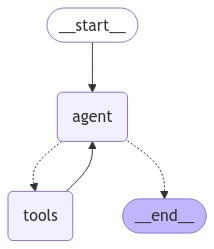

In [105]:
from IPython.display import Image, display

display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [104]:
'wger'.count

'0b110101100001'